# Calculate MFCC

2018-07-24

Refs:
- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import IPython.display as ipd
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.fftpack import dct

## Load sound file

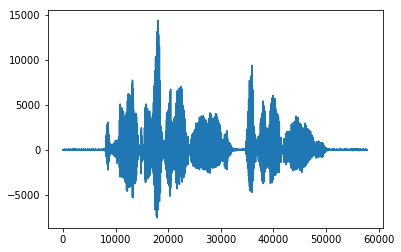

In [2]:
wav_file = 'mngu0_s1_0001.wav'
sample_rate, sig = wavfile.read(wav_file)
fig, ax = plt.subplots(facecolor='white')
ax.plot(sig)
ymin, ymax = ax.get_ylim()
# Play audio
ipd.Audio(sig, rate=sample_rate)

## Pre-emphasis

This step amplify the high frequencies. High frequencies usually low in magnitude. Pre-emphasis step increases there magnitudes, improve SNR ratio, and avoid numerical issues in calculating FFT operation.

$y(t) = x(t) - \alpha x(t-1)$

In [3]:
pre_emp = 0.97
sig_emp = np.append(sig[0], sig[1:] - pre_emp*sig[:-1])

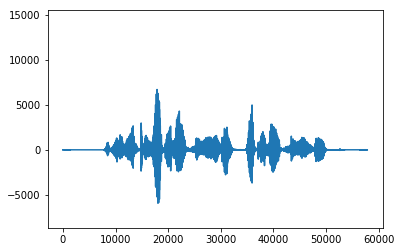

In [4]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(sig_emp)
ax.set_ylim(ymin, ymax)
# Play audio
ipd.Audio(sig_emp, rate=sample_rate)

## Framing

In [5]:
# Set frame time
frame_size = 0.025
frame_shift = 0.01
# Get samples
frame_len = int(frame_size * sample_rate) # 400
frame_step = int(frame_shift * sample_rate) # 160
sig_len = len(sig_emp) # 57862
# Get number of frames
num_frames = int(np.ceil(np.abs(sig_len - frame_len) / frame_step)) # 359.13 -> 360

In [6]:
# Pad signal
pad_sig_len = num_frames * frame_step + frame_len # 58000
pad = np.zeros((pad_sig_len - sig_len)) # 138
sig_pad = np.append(sig_emp, pad) # 58000

In [7]:
# Get within-frame sample indices
idx1 = np.tile(np.arange(0, frame_len), (num_frames, 1)) # 360 x 400
idx1

array([[  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       ...,
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399]])

In [8]:
# Get vectors of frame step increments
idx2 = np.tile(np.arange(0, num_frames*frame_step, frame_step), ((frame_len, 1))).T
idx2

array([[    0,     0,     0, ...,     0,     0,     0],
       [  160,   160,   160, ...,   160,   160,   160],
       [  320,   320,   320, ...,   320,   320,   320],
       ...,
       [57120, 57120, 57120, ..., 57120, 57120, 57120],
       [57280, 57280, 57280, ..., 57280, 57280, 57280],
       [57440, 57440, 57440, ..., 57440, 57440, 57440]])

In [9]:
# Get total indices divided by each frame
indices = idx1 + idx2
indices

array([[    0,     1,     2, ...,   397,   398,   399],
       [  160,   161,   162, ...,   557,   558,   559],
       [  320,   321,   322, ...,   717,   718,   719],
       ...,
       [57120, 57121, 57122, ..., 57517, 57518, 57519],
       [57280, 57281, 57282, ..., 57677, 57678, 57679],
       [57440, 57441, 57442, ..., 57837, 57838, 57839]])

In [10]:
# Get frames divided by each frame based on indices
frames = sig_pad[indices.astype(np.int32, copy=False)]
frames

array([[ 0.  ,  0.  ,  0.  , ..., -1.52,  2.42, -0.52],
       [ 2.03,  2.09,  0.15, ..., -1.43,  3.51,  0.6 ],
       [-1.26,  2.65,  2.68, ..., -3.28,  4.6 , -1.28],
       ...,
       [ 9.74,  3.98,  4.04, ...,  1.29, -5.71,  1.08],
       [ 2.46,  1.55, -3.39, ...,  3.49,  7.61,  9.85],
       [ 4.6 ,  5.72,  4.87, ...,  0.  ,  0.  ,  0.  ]])

## Windowing

In [11]:
frames *= np.hamming(frame_len)
frames

array([[ 0.        ,  0.        ,  0.        , ..., -0.12194674,
         0.19373802, -0.0416    ],
       [ 0.1624    ,  0.1673192 ,  0.01203422, ..., -0.11472621,
         0.28100019,  0.048     ],
       [-0.1008    ,  0.21215114,  0.21501137, ..., -0.26314824,
         0.36826236, -0.1024    ],
       ...,
       [ 0.7792    ,  0.31862699,  0.32412161, ...,  0.10349428,
        -0.45712566,  0.0864    ],
       [ 0.1968    ,  0.1240884 , -0.27197333, ...,  0.27999614,
         0.60923403,  0.788     ],
       [ 0.368     ,  0.45792623,  0.39071095, ...,  0.        ,
         0.        ,  0.        ]])

## Short-Time Fourier-Transform (STFT)

$N$-point FFT

$P = \frac{\lvert FFT(x_i) \rvert^2}{N}$

In [12]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, n=NFFT)) # frames x (NFFT//2+1); 360 x 257
pow_frames = ((1/NFFT) * ((mag_frames)**2)) # 360 x 257

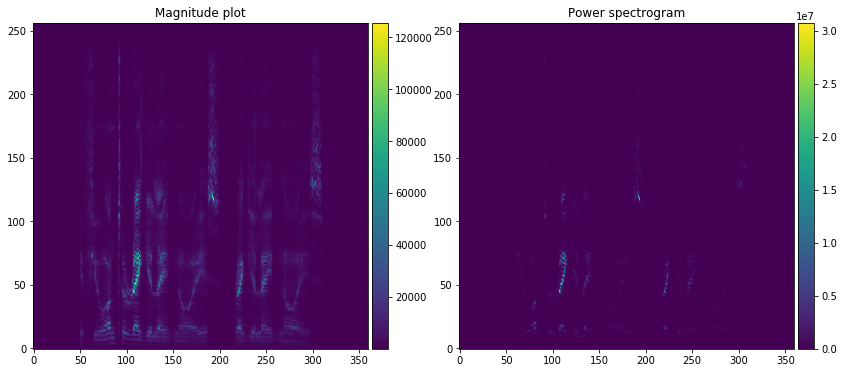

In [13]:
# Magnitude
fig, arr = plt.subplots(1, 2, facecolor='white', figsize=(14,6))
im1 = arr[0].imshow(mag_frames.T, aspect='auto', origin='lower')
arr[0].set_title('Magnitude plot')
divider = make_axes_locatable(arr[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, cax=cax)
# Power spectrogram
im2 = arr[1].imshow(pow_frames.T, aspect='auto', origin='lower')
arr[1].set_title('Power spectrogram')
divider = make_axes_locatable(arr[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2, cax=cax)

## Filter banks

Steps:

FFT -> Mel scale (Hz -> Mel) -> Apply triangular filters

In [14]:
nfilt = 40
low_freq_mel = 0
# Convert Hz to Mel
high_freq_mel = (2595 * np.log10(1 + (sample_rate/2)/700))
# Get mel points (equally spaced)
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
# Convert Mel to Hz
hz_points = (700 * (10**(mel_points/2595) - 1))
hz_points

array([   0.        ,   44.37407701,   91.56109503,  141.73937073,
        195.09852453,  251.84019719,  312.17881177,  376.34238398,
        444.57338374,  517.12965156,  594.28537283,  676.33211398,
        763.57992429,  856.35850754,  955.01846792, 1059.93263499,
       1171.49747253, 1290.13457677, 1416.29226959, 1550.44729265,
       1693.10660904, 1844.80931898, 2006.12869712, 2177.67435884,
       2360.094564  , 2554.07866662, 2760.35971998, 2979.71724669,
       3212.98018452, 3461.03001887, 3724.80411386, 4005.29925458,
       4303.57541383, 4620.75975774, 4958.05090523, 5316.72345751,
       5698.13281472, 6103.72029792, 6535.01859571, 6993.65755619,
       7481.37034603, 8000.        ])

In [15]:
high_freq_mel

2840.023046708319

In [16]:
# Get frequency bins -> ??
bins = np.floor((NFFT + 1)*hz_points / sample_rate)
bins

array([  0.,   1.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  19.,
        21.,  24.,  27.,  30.,  33.,  37.,  41.,  45.,  49.,  54.,  59.,
        64.,  69.,  75.,  81.,  88.,  95., 103., 110., 119., 128., 137.,
       148., 158., 170., 182., 195., 209., 224., 239., 256.])

$H_m(k)$: $m$th Mel filter bank of the $k$th bin

In [17]:
# Filter banks
fbank = np.zeros((nfilt, int(np.floor(NFFT/2 + 1))))
# For each filter bank
for m in range(1, nfilt + 1): # 1, 2, ... 40
    f_m_minus = int(bins[m-1]) # left
    f_m = int(bins[m])         # center
    f_m_plus = int(bins[m+1])  # right
    
    # For left bins within filter bank
    for k in range(f_m_minus, f_m):
        fbank[m-1, k] = (k - bins[m-1]) / (bins[m] - bins[m-1])
    # For right bins within filter bank
    for k in range(f_m, f_m_plus):
        fbank[m-1, k] = (bins[m+1] - k) / (bins[m+1] - bins[m])

Text(0.5,1,'Log spectrogram')

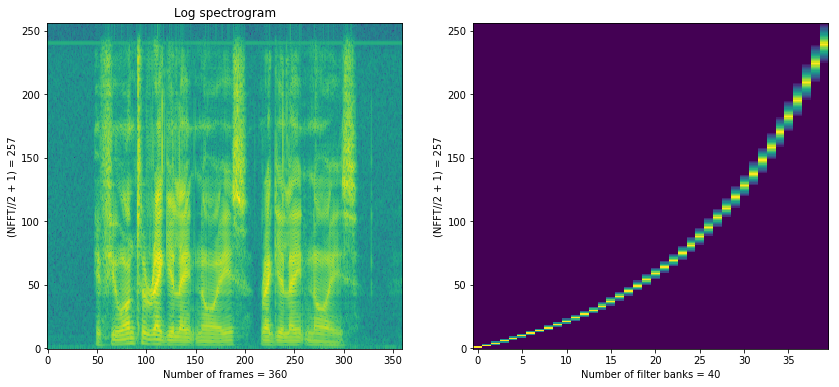

In [18]:
fig, arr = plt.subplots(1,2, facecolor='white', figsize=(14, 6))
arr[1].imshow(fbank.T, aspect='auto', origin='lower')
arr[1].set_xlabel('Number of filter banks = 40')
arr[1].set_ylabel('(NFFT//2 + 1) = 257')
arr[0].imshow(20*np.log10(pow_frames).T, aspect='auto', origin='lower')
arr[0].set_xlabel('Number of frames = 360')
arr[0].set_ylabel('(NFFT//2 + 1) = 257')
arr[0].set_title('Log spectrogram')

In [19]:
# Finalize
filter_banks = np.dot(pow_frames, fbank.T) # convolution!
# Add eps for numerical stability
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks) # to dB

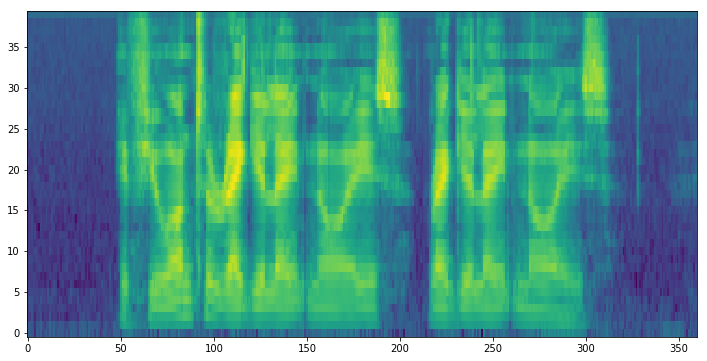

In [20]:
fig, ax = plt.subplots(facecolor='white', figsize=(12,6))
ax.imshow(filter_banks.T, aspect='auto', origin='lower')